In [ ]:
!pip install tensorflow==2.10.0

In [ ]:
!pip install sentencepiece

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Flatten, Input, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
!pip install transformers
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
#load dataset
df = pd.read_csv("Final_preprocessed_dataset_portuguese.csv")
#df.fillna('', inplace=True)

In [ ]:
def plot_train_val_loss_acc(history):
    # plot learning curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # plot validation curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
from transformers import XLMRobertaTokenizer, TFXLMRobertaModel
X = df['Text'].values
y = df['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the XLM-R tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Tokenize the input texts
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# Save tokenized data
with open('X_train_tokenized_XLMR_base_cased.pkl', 'wb') as f:
     pickle.dump(X_train_tokenized, f)

with open('X_test_tokenized_XLMR_base_cased.pkl', 'wb') as f:
     pickle.dump(X_test_tokenized, f)

# Load tokenized data
with open('X_train_tokenized_XLMR_base_cased.pkl', 'rb') as f:
  X_train_tokenized = pickle.load(f)

with open('X_test_tokenized_XLMR_base_cased.pkl', 'rb') as f:
  X_test_tokenized = pickle.load(f)

In [ ]:
# Load the pre-trained XLM-R model
xlmr_model = TFXLMRobertaModel.from_pretrained('xlm-roberta-base')

# Freeze the pre-trained layers
for layer in xlmr_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')

# Pass the input through the pre-trained XLM-R model
sequence_output = xlmr_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [ ]:
# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)]
)

Epoch 1/10
791/791 [==============================] - 584s 720ms/step - loss: 0.3640 - accuracy: 0.8475 - val_loss: 0.4152 - val_accuracy: 0.8140
Epoch 2/10
791/791 [==============================] - 567s 717ms/step - loss: 0.2481 - accuracy: 0.8954 - val_loss: 0.2788 - val_accuracy: 0.8838
Epoch 3/10
791/791 [==============================] - 568s 719ms/step - loss: 0.2082 - accuracy: 0.9129 - val_loss: 0.2435 - val_accuracy: 0.8981
Epoch 4/10
791/791 [==============================] - 567s 717ms/step - loss: 0.1827 - accuracy: 0.9261 - val_loss: 0.2834 - val_accuracy: 0.8803
Epoch 5/10
791/791 [==============================] - 566s 716ms/step - loss: 0.1674 - accuracy: 0.9323 - val_loss: 0.2713 - val_accuracy: 0.8933
Epoch 6/10
791/791 [==============================] - 568s 718ms/step - loss: 0.1519 - accuracy: 0.9381 - val_loss: 0.2532 - val_accuracy: 0.8987
Epoch 7/10
791/791 [==============================] - 567s 717ms/step - loss: 0.1442 - accuracy: 0.9423 - val_loss: 0.2469 -

In [ ]:
plot_train_val_loss_acc(history)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=64)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

198/198 [==============================] - 107s 541ms/step - loss: 0.2833 - accuracy: 0.8989
Test loss: 0.283, Test accuracy: 0.899


396/396 [==============================] - 113s 285ms/step
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      6285
           1       0.87      0.94      0.90      6363

    accuracy                           0.90     12648
   macro avg       0.90      0.90      0.90     12648
weighted avg       0.90      0.90      0.90     12648



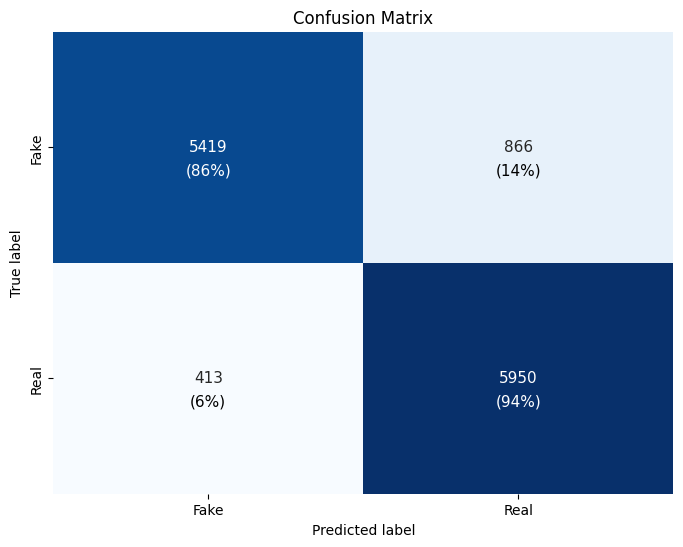

In [ ]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

# Compute normalized values
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'], annot_kws={"fontsize": 11})

# Add normalized values below the actual values
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        text_color = 'black' if conf_mat_norm[i, j] < 0.5 else 'white'
        ax.text(j + 0.5, i + 0.6, f'({conf_mat_norm[i, j]:.0%})', ha='center', va='center', color=text_color, fontsize=11)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()